In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os


In [2]:
# Load Data
df = pd.read_csv("all_sources_metadata_2020-03-13.csv")
print("Shape:", df.shape)
df.head()


Shape: (29500, 14)


,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


In [3]:
# Explore
df.info()
df.describe()
df.isnull().sum().head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sha                          17420 non-null  object 
 1   source_x                     29500 non-null  object 
 2   title                        29491 non-null  object 
 3   doi                          26357 non-null  object 
 4   pmcid                        27337 non-null  object 
 5   pubmed_id                    16730 non-null  float64
 6   license                      17692 non-null  object 
 7   abstract                     26909 non-null  object 
 8   publish_time                 18604 non-null  object 
 9   authors                      28903 non-null  object 
 10  journal                      17791 non-null  object 
 11  Microsoft Academic Paper ID  1134 non-null   float64
 12  WHO #Covidence               1236 non-null   object 
 13  has_full_text   

sha                            12080
source_x                           0
title                              9
doi                             3143
pmcid                           2163
pubmed_id                      12770
license                        11808
abstract                        2591
publish_time                   10896
authors                          597
journal                        11709
Microsoft Academic Paper ID    28366
WHO #Covidence                 28264
has_full_text                  12080
dtype: int64

In [9]:
# Drop columns with >80% missing values
threshold = 0.8 * len(df)
df_clean = df.dropna(axis=1, thresh=threshold)

# Detect publish time column
date_candidates = ["publish_time", "publish_date", "date"]
date_col = next((c for c in date_candidates if c in df_clean.columns), None)

if date_col:
    df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors="coerce")
    df_clean["year"] = df_clean[date_col].dt.year
else:
    print("⚠️ No publish date column found; skipping year analysis.")
    df_clean["year"] = None

# Abstract word count
if "abstract" in df_clean.columns:
    df_clean["abstract_word_count"] = df_clean["abstract"].fillna("").apply(lambda x: len(x.split()))

print("Shape after cleaning:", df_clean.shape)
df_clean.head()


⚠️ No publish date column found; skipping year analysis.


C:\Users\Abu AbdirRahman\AppData\Local\Temp\ipykernel_29096\1242892729.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["year"] = None


Shape after cleaning: (29500, 8)


C:\Users\Abu AbdirRahman\AppData\Local\Temp\ipykernel_29096\1242892729.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["abstract_word_count"] = df_clean["abstract"].fillna("").apply(lambda x: len(x.split()))


,source_x,title,doi,pmcid,abstract,authors,year,abstract_word_count
0,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,NaN,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",None,0
1,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",None,0
2,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,The geographic spread of 2019 novel coronaviru...,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",None,166
3,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,"In December 2019, cases of unidentified pneumo...","Deng, Sheng-Qun; Peng, Hong-Juan",None,211
4,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,NaN,"Zhang, Wei",None,0


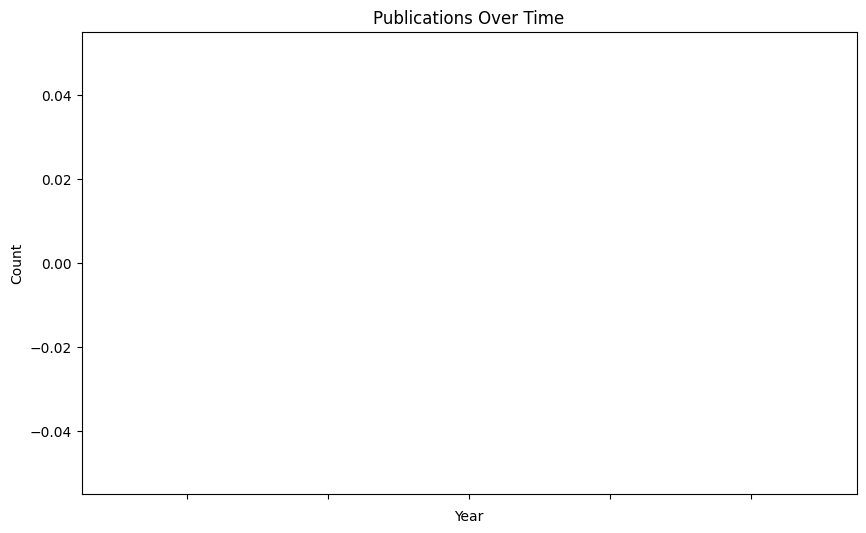

In [10]:
# Publications per Year
os.makedirs("outputs", exist_ok=True)
papers_per_year = df_clean["year"].value_counts().sort_index()
papers_per_year.plot(kind="line", marker="o", figsize=(10,6), title="Publications Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.savefig("outputs/publications_over_time.png")
plt.show()


In [ ]:
# top_journals
journal_candidates = ["journal", "journal_name", "publication", "source"]
journal_col = next((c for c in journal_candidates if c in df_clean.columns), None)

if journal_col:
    top_journals = df_clean[journal_col].value_counts().head(10)
    sns.barplot(y=top_journals.index, x=top_journals.values)
    plt.title("Top 10 Journals by Publication Count")
    plt.xlabel("Count")
    plt.ylabel("Journal")
    plt.savefig("outputs/top_journals.png")
    plt.show()
else:
    print("⚠️ No journal column found; skipping top journals analysis.")


⚠️ No journal column found; skipping top journals analysis.


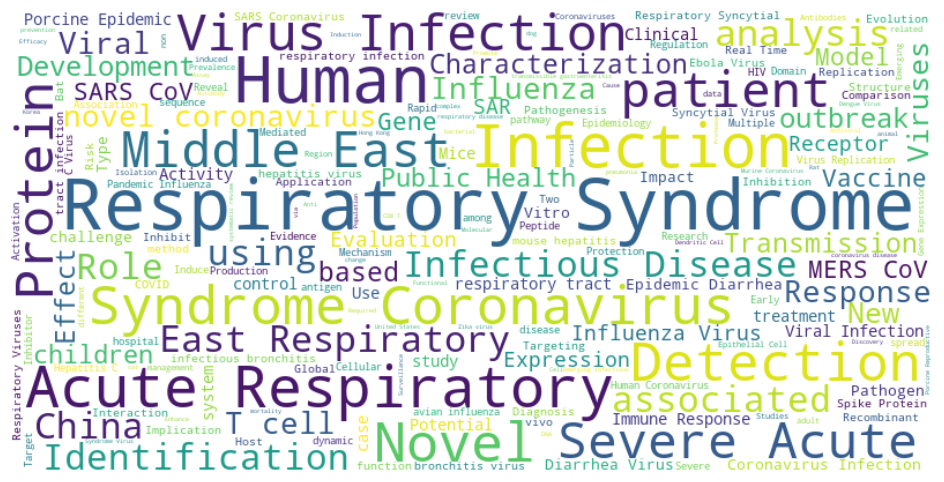

In [12]:
# Wordcloud of Titles
titles = " ".join(df_clean["title"].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(titles)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("outputs/title_wordcloud.png")
plt.show()

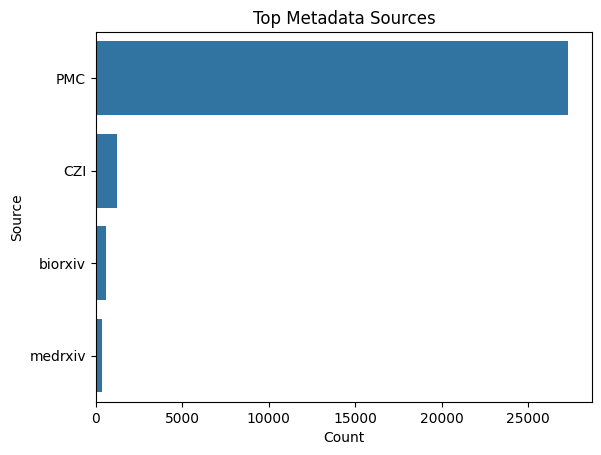

In [13]:
# Sources
if "source_x" in df_clean.columns:
    source_counts = df_clean["source_x"].value_counts().head(10)
    sns.barplot(y=source_counts.index, x=source_counts.values)
    plt.title("Top Metadata Sources")
    plt.xlabel("Count")
    plt.ylabel("Source")
    plt.savefig("outputs/top_sources.png")
    plt.show()

In [14]:
# Save Cleaned Data
df_clean.to_csv("outputs/metadata_cleaned.csv", index=False)
print("Saved cleaned dataset to outputs/metadata_cleaned.csv")

Saved cleaned dataset to outputs/metadata_cleaned.csv
